# Job Search III: Search with Learning

## Contents

- [Job Search III: Search with Learning](#Job-Search-III:-Search-with-Learning)  
  - [Overview](#Overview)  
  - [Model](#Model)  
  - [Take 1: Solution by VFI](#Take-1:-Solution-by-VFI)  
  - [Take 2: A More Efficient Method](#Take-2:-A-More-Efficient-Method)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  
  - [Appendix](#Appendix)  

## Overview

In this lecture we consider an extension of the [previously studied](https://lectures.quantecon.org/py/mccall_model.html#) job search model of McCall [[McC70]](https://lectures.quantecon.org/py/zreferences.html#mccall1970)

In the McCall model, an unemployed worker decides when to accept a permanent position at a specified wage, given

- his or her discount rate  
- the level of unemployment compensation  
- the distribution from which wage offers are drawn  


In the version considered below, the wage distribution is unknown and must be learned

- The following is based on the presentation in [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012), section 6.6  


Let’s start with some imports

In [1]:
from numba import njit, prange, vectorize
from interpolation import mlinterp, interp
from math import gamma
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

### Model features

- Infinite horizon dynamic programming with two states and one binary control  
- Bayesian updating to learn the unknown distribution  

## Model


<a id='index-0'></a>
Let’s first review the basic McCall model [[McC70]](https://lectures.quantecon.org/py/zreferences.html#mccall1970) and then add the variation we want to consider

### The Basic McCall Model


<a id='index-1'></a>
Recall that, [in the baseline model](https://lectures.quantecon.org/py/mccall_model.html#), an unemployed worker is presented in each period with a
permanent job offer at wage $ W_t $

At time $ t $, our worker either

1. accepts the offer and works permanently at constant wage $ W_t $  
1. rejects the offer, receives unemployment compensation $ c $ and reconsiders next period  


The wage sequence $ \{W_t\} $ is iid and generated from known density $ q $

The worker aims to maximize the expected discounted sum of earnings $ \mathbb{E} \sum_{t=0}^{\infty} \beta^t y_t $
The function $ V $ satisfies the recursion


<a id='equation-odu-odu-pv'></a>
$$
v(w)
= \max \left\{
\frac{w}{1 - \beta}, \, c + \beta \int v(w')q(w') dw'
\right\} \tag{1}
$$

The optimal policy has the form $ \mathbf{1}\{w \geq \bar w\} $, where
$ \bar w $ is a constant depending called the *reservation wage*

### Offer Distribution Unknown

Now let’s extend the model by considering the variation presented in [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012), section 6.6

The model is as above, apart from the fact that

- the density $ q $ is unknown  
- the worker learns about $ q $ by starting with a prior and updating based on wage offers that he/she observes  


The worker knows there are two possible distributions $ F $ and $ G $ — with densities $ f $ and $ g $

At the start of time, “nature” selects $ q $ to be either $ f $ or
$ g $ — the wage distribution from which the entire sequence $ \{W_t\} $ will be drawn

This choice is not observed by the worker, who puts prior probability $ \pi_0 $ on $ f $ being chosen

Update rule: worker’s time $ t $ estimate of the distribution is $ \pi_t f + (1 - \pi_t) g $, where $ \pi_t $ updates via


<a id='equation-odu-pi-rec'></a>
$$
\pi_{t+1}
= \frac{\pi_t f(w_{t+1})}{\pi_t f(w_{t+1}) + (1 - \pi_t) g(w_{t+1})} \tag{2}
$$

This last expression follows from Bayes’ rule, which tells us that

$$
\mathbb{P}\{q = f \,|\, W = w\}
= \frac{\mathbb{P}\{W = w \,|\, q = f\}\mathbb{P}\{q = f\}}
{\mathbb{P}\{W = w\}}
\quad \text{and} \quad
\mathbb{P}\{W = w\} = \sum_{\omega \in \{f, g\}} \mathbb{P}\{W = w \,|\, q = \omega\} \mathbb{P}\{q = \omega\}
$$

The fact that [(2)](#equation-odu-pi-rec) is recursive allows us to progress to a recursive solution method

Letting

$$
q_{\pi}(w) := \pi f(w) + (1 - \pi) g(w)
\quad \text{and} \quad
\kappa(w, \pi) := \frac{\pi f(w)}{\pi f(w) + (1 - \pi) g(w)}
$$

we can express the value function for the unemployed worker recursively as
follows


<a id='equation-odu-mvf'></a>
$$
v(w, \pi)
= \max \left\{
\frac{w}{1 - \beta}, \, c + \beta \int v(w', \pi') \, q_{\pi}(w') \, dw'
\right\}
\quad \text{where} \quad
\pi' = \kappa(w', \pi) \tag{3}
$$

Notice that the current guess $ \pi $ is a state variable, since it affects the worker’s perception of probabilities for future rewards

### Parameterization

Following  section 6.6 of [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012), our baseline parameterization will be

- $ f $ is $ \operatorname{Beta}(1, 1) $  
- $ g $ is $ \operatorname{Beta}(3, 1.2) $  
- $ \beta = 0.95 $ and $ c = 0.3 $  


The densities $ f $ and $ g $ have the following shape

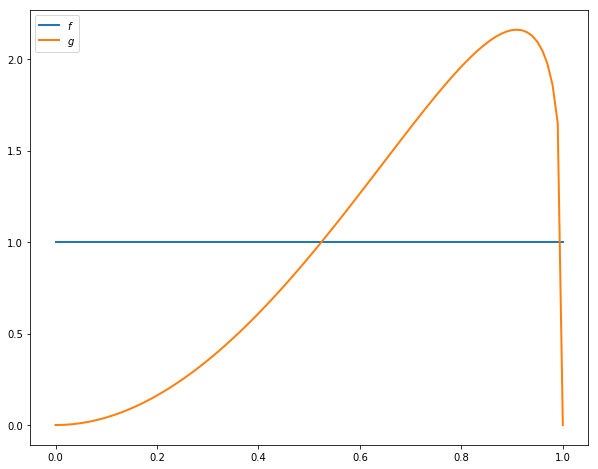

In [2]:
def beta_function_factory(a, b):

    @vectorize
    def p(x):
        r = gamma(a + b) / (gamma(a) * gamma(b))
        return r * x**(a-1) * (1 - x)**(b-1)

    return p


x_grid = np.linspace(0, 1, 100)
f = beta_function_factory(1, 1)
g = beta_function_factory(3, 1.2)

plt.figure(figsize=(10, 8))
plt.plot(x_grid, f(x_grid), label='$f$', lw=2)
plt.plot(x_grid, g(x_grid), label='$g$', lw=2)

plt.legend()
plt.show()


<a id='looking-forward'></a>

### Looking Forward

What kind of optimal policy might result from [(3)](#equation-odu-mvf) and the parameterization specified above?

Intuitively, if we accept at $ w_a $ and $ w_a \leq w_b $, then — all other things being given — we should also accept at $ w_b $

This suggests a policy of accepting whenever $ w $ exceeds some threshold value $ \bar w $

But $ \bar w $ should depend on $ \pi $ — in fact it should be decreasing in $ \pi $ because

- $ f $ is a less attractive offer distribution than $ g $  
- larger $ \pi $ means more weight on $ f $ and less on $ g $  


Thus larger $ \pi $ depresses the worker’s assessment of her future prospects, and relatively low current offers become more attractive

**Summary:**  We conjecture that the optimal policy is of the form
$ \mathbb 1\{w \geq \bar w(\pi) \} $ for some decreasing function
$ \bar w $

## Take 1: Solution by VFI

Let’s set about solving the model and see how our results match with our intuition

We begin by solving via value function iteration (VFI), which is natural but ultimately turns out to be second best

The class `SearchProblem` is used to store parameters and methods needed to compute optimal actions


<a id='odu-vfi-code'></a>

In [3]:
class SearchProblem:
    """
    A class to store a given parameterization of the "offer distribution
    unknown" model.

    """

    def __init__(self,
                 β=0.95,            # Discount factor
                 c=0.3,             # Unemployment compensation
                 F_a=1,
                 F_b=1,
                 G_a=3,
                 G_b=1.2,
                 w_max=1,           # Maximum wage possible
                 w_grid_size=100,
                 π_grid_size=100,
                 mc_size=500):

        self.β, self.c, self.w_max = β, c, w_max

        self.f = beta_function_factory(F_a, F_b)
        self.g = beta_function_factory(G_a, G_b)

        self.π_min, self.π_max = 1e-3, 1-1e-3    # Avoids instability
        self.w_grid = np.linspace(0, w_max, w_grid_size)
        self.π_grid = np.linspace(self.π_min, self.π_max, π_grid_size)

        self.mc_size = mc_size

        self.w_f = np.random.beta(F_a, F_b, mc_size)
        self.w_g = np.random.beta(G_a, G_b, mc_size)

The following function takes an instance of this class and returns jitted versions
of the Bellman operator `T`, and a `get_greedy()` function to compute the approximate
optimal policy from a guess `v` of the value function

In [4]:
def operator_factory(sp, parallel_flag=True):

    f, g = sp.f, sp.g
    w_f, w_g = sp.w_f, sp.w_g
    β, c = sp.β, sp.c
    mc_size = sp.mc_size
    w_grid, π_grid = sp.w_grid, sp.π_grid

    @njit
    def κ(w, π):
        """
        Updates π using Bayes' rule and the current wage observation w.
        """
        pf, pg = π * f(w), (1 - π) * g(w)
        π_new = pf / (pf + pg)

        return π_new

    @njit(parallel=parallel_flag)
    def T(v):
        """
        The Bellman operator.

        """
        v_func = lambda x, y: mlinterp((w_grid, π_grid), v, (x, y))
        v_new = np.empty_like(v)

        for i in prange(len(w_grid)):
            for j in prange(len(π_grid)):
                w = w_grid[i]
                π = π_grid[j]

                v_1 = w / (1 - β)

                integral_f, integral_g = 0.0, 0.0
                for m in prange(mc_size):
                    integral_f += v_func(w_f[m], κ(w_f[m], π))
                    integral_g += v_func(w_g[m], κ(w_g[m], π))
                integral = (π * integral_f + (1 - π) * integral_g) / mc_size

                v_2 = c + β * integral
                v_new[i, j] = max(v_1, v_2)

        return v_new

    @njit(parallel=parallel_flag)
    def get_greedy(v):
        """"
        Compute optimal actions taking v as the value function.

        """

        v_func = lambda x, y: mlinterp((w_grid, π_grid), v, (x, y))
        σ = np.empty_like(v)

        for i in prange(len(w_grid)):
            for j in prange(len(π_grid)):
                w = w_grid[i]
                π = π_grid[j]

                v_1 = w / (1 - β)

                integral_f, integral_g = 0.0, 0.0
                for m in prange(mc_size):
                    integral_f += v_func(w_f[m], κ(w_f[m], π))
                    integral_g += v_func(w_g[m], κ(w_g[m], π))
                integral = (π * integral_f + (1 - π) * integral_g) / mc_size

                v_2 = c + β * integral

                σ[i, j] = v_1 > v_2  # Evaluates to 1 or 0

        return σ

    return T, get_greedy

We will omit a detailed discussion of the code because there is a
more efficient solution method that we will use later

To solve the model we will use the following function that iterates using
T to find a fixed point

In [5]:
def solve_model(sp,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=5):

    """
    Solves for the value function

    * sp is an instance of SearchProblem
    """

    T, _ = operator_factory(sp, use_parallel)

    # Set up loop
    i = 0
    error = tol + 1
    m, n = len(sp.w_grid), len(sp.π_grid)

    # Initialize v
    v = np.zeros((m, n)) + sp.c / (1 - sp.β)

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")


    return v_new

Let’s look at solutions computed from value function iteration

Error at iteration 5 is 0.6432566576783287.


Error at iteration 10 is 0.1082147711792345.


Error at iteration 15 is 0.02306325345680449.


Error at iteration 20 is 0.005302446338129485.


Error at iteration 25 is 0.0012196381240610066.


Error at iteration 30 is 0.00028053418879814274.



Converged in 34 iterations.


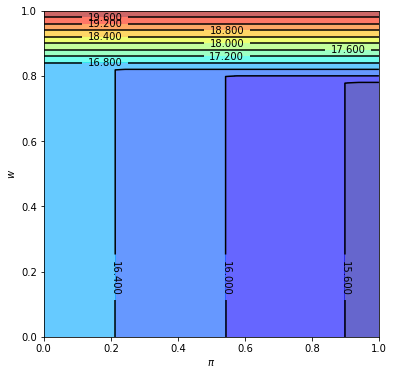

In [6]:
sp = SearchProblem()
v_star = solve_model(sp)
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(sp.π_grid, sp.w_grid, v_star, 12, alpha=0.6, cmap=cm.jet)
cs = ax.contour(sp.π_grid, sp.w_grid, v_star, 12, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
ax.set(xlabel='$\pi$', ylabel='$w$')

plt.show()


<a id='odu-pol-vfi'></a>
We will also plot the optimal policy

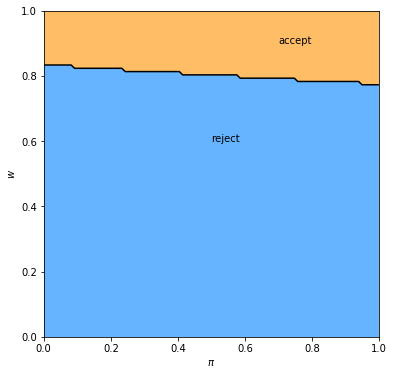

In [7]:
T, get_greedy = operator_factory(sp)
σ_star = get_greedy(v_star)

fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(sp.π_grid, sp.w_grid, σ_star, 1, alpha=0.6, cmap=cm.jet)
ax.contour(sp.π_grid, sp.w_grid, σ_star, 1, colors="black")
ax.set(xlabel='$\pi$', ylabel='$w$')

ax.text(0.5, 0.6, 'reject')
ax.text(0.7, 0.9, 'accept')

plt.show()

The results fit well with our intuition from section [looking forward](#looking-forward)

- The black line in the figure above corresponds to the function $ \bar w(\pi) $ introduced there  
- It is decreasing as expected  

## Take 2: A More Efficient Method

Let’s consider another method to solve for the optimal policy

We will use iteration with an operator that has the same contraction rate as the Bellman operator, but

- one dimensional rather than two dimensional  
- no maximization step  


As a consequence, the algorithm is orders of magnitude faster than VFI

This section illustrates the point that when it comes to programming, a bit of
mathematical analysis goes a long way

### Another Functional Equation

To begin, note that when $ w = \bar w(\pi) $, the worker is indifferent
between accepting and rejecting

Hence the two choices on the right-hand side of [(3)](#equation-odu-mvf) have equal value:


<a id='equation-odu-mvf2'></a>
$$
\frac{\bar w(\pi)}{1 - \beta}
= c + \beta \int v(w', \pi') \, q_{\pi}(w') \, dw' \tag{4}
$$

Together, [(3)](#equation-odu-mvf) and [(4)](#equation-odu-mvf2) give


<a id='equation-odu-mvf3'></a>
$$
v(w, \pi) =
\max
\left\{
    \frac{w}{1 - \beta} ,\, \frac{\bar w(\pi)}{1 - \beta}
\right\} \tag{5}
$$

Combining [(4)](#equation-odu-mvf2) and [(5)](#equation-odu-mvf3), we obtain

$$
\frac{\bar w(\pi)}{1 - \beta}
= c + \beta \int \max \left\{
    \frac{w'}{1 - \beta} ,\, \frac{\bar w(\pi')}{1 - \beta}
\right\}
\, q_{\pi}(w') \, dw'
$$

Multiplying by $ 1 - \beta $, substituting in $ \pi' = \kappa(w', \pi) $
and using $ \circ $ for composition of functions yields


<a id='equation-odu-mvf4'></a>
$$
\bar w(\pi)
= (1 - \beta) c +
\beta \int \max \left\{ w', \bar w \circ \kappa(w', \pi) \right\} \, q_{\pi}(w') \, dw' \tag{6}
$$

Equation [(6)](#equation-odu-mvf4) can be understood as a functional equation, where $ \bar w $ is the unknown function

- Let’s call it the *reservation wage functional equation* (RWFE)  
- The solution $ \bar w $ to the RWFE is the object that we wish to compute  

### Solving the RWFE

To solve the RWFE, we will first show that its solution is the
fixed point of a [contraction mapping](https://en.wikipedia.org/wiki/Contraction_mapping)

To this end, let

- $ b[0,1] $ be the bounded real-valued functions on $ [0,1] $  
- $ \| \omega \| := \sup_{x \in [0,1]} | \omega(x) | $  


Consider the operator $ Q $ mapping $ \omega \in b[0,1] $ into $ Q\omega \in b[0,1] $ via


<a id='equation-odu-dq'></a>
$$
(Q \omega)(\pi)
= (1 - \beta) c +
\beta \int \max \left\{ w', \omega \circ \kappa(w', \pi) \right\} \, q_{\pi}(w') \, dw' \tag{7}
$$

Comparing [(6)](#equation-odu-mvf4) and [(7)](#equation-odu-dq), we see that the set of fixed points of $ Q $ exactly coincides with the set of solutions to the RWFE

- If $ Q \bar w = \bar w $ then $ \bar w $ solves [(6)](#equation-odu-mvf4) and vice versa  


Moreover, for any $ \omega, \omega' \in b[0,1] $, basic algebra and the
triangle inequality for integrals tells us that


<a id='equation-odu-nt'></a>
$$
|(Q \omega)(\pi) - (Q \omega')(\pi)|
\leq \beta \int
\left|
\max \left\{w', \omega \circ \kappa(w', \pi) \right\} -
\max \left\{w', \omega' \circ \kappa(w', \pi) \right\}
\right|
\, q_{\pi}(w') \, dw' \tag{8}
$$

Working case by case, it is easy to check that for real numbers $ a, b, c $ we always have


<a id='equation-odu-nt2'></a>
$$
| \max\{a, b\} - \max\{a, c\}| \leq | b - c| \tag{9}
$$

Combining [(8)](#equation-odu-nt) and [(9)](#equation-odu-nt2) yields


<a id='equation-odu-nt3'></a>
$$
|(Q \omega)(\pi) - (Q \omega')(\pi)|
\leq \beta \int
\left| \omega \circ \kappa(w', \pi) -  \omega' \circ \kappa(w', \pi) \right|
\, q_{\pi}(w') \, dw'
\leq \beta \| \omega - \omega' \| \tag{10}
$$

Taking the supremum over $ \pi $ now gives us


<a id='equation-odu-rwc'></a>
$$
\|Q \omega - Q \omega'\|
\leq \beta \| \omega - \omega' \| \tag{11}
$$

In other words, $ Q $ is a contraction of modulus $ \beta $ on the
complete metric space $ (b[0,1], \| \cdot \|) $

Hence

- A unique solution $ \bar w $ to the RWFE exists in $ b[0,1] $  
- $ Q^k \omega \to \bar w $ uniformly as $ k \to \infty $, for any $ \omega \in b[0,1] $  

#### Implementation

The following function takes an instance of `SearchProblem` and returns the
operator `Q`

In [8]:
def Q_factory(sp, parallel_flag=True):

    f, g = sp.f, sp.g
    w_f, w_g = sp.w_f, sp.w_g
    β, c = sp.β, sp.c
    mc_size = sp.mc_size
    w_grid, π_grid = sp.w_grid, sp.π_grid

    @njit
    def κ(w, π):
        """
        Updates π using Bayes' rule and the current wage observation w.
        """
        pf, pg = π * f(w), (1 - π) * g(w)
        π_new = pf / (pf + pg)

        return π_new

    @njit
    def Q(ω):
        """

        Updates the reservation wage function guess ω via the operator
        Q.

        """
        ω_func = lambda p: interp(π_grid, ω, p)
        ω_new = np.empty_like(ω)

        for i in prange(len(π_grid)):
            π = π_grid[i]
            integral_f, integral_g = 0.0, 0.0

            for m in prange(mc_size):
                integral_f += max(w_f[m], ω_func(κ(w_f[m], π)))
                integral_g += max(w_g[m], ω_func(κ(w_g[m], π)))
            integral = (π * integral_f + (1 - π) * integral_g) / mc_size

            ω_new[i] = (1 - β) * c + β * integral

        return ω_new

    return Q

In the next exercise you are asked to compute an approximation to $ \bar w $

## Exercises


<a id='odu-ex1'></a>

### Exercise 1

Use the default parameters and `Q_factory` to compute an optimal policy

Your result should coincide closely with the figure for the optimal policy [shown above](#odu-pol-vfi)

Try experimenting with different parameters, and confirm that the change in
the optimal policy coincides with your intuition

## Solutions

### Exercise 1

This code solves the “Offer Distribution Unknown” model by iterating on
a guess of the reservation wage function

You should find that the run time is shorter than that of the value
function approach

Similar to above, we set up a function to iterate with `Q` to find the fixed point

In [9]:
def solve_wbar(sp,
               use_parallel=True,
               tol=1e-4,
               max_iter=1000,
               verbose=True,
               print_skip=5):

    Q = Q_factory(sp, use_parallel)

    # Set up loop
    i = 0
    error = tol + 1
    m, n = len(sp.w_grid), len(sp.π_grid)

    # Initialize w
    w = np.ones_like(sp.π_grid)

    while i < max_iter and error > tol:
        w_new = Q(w)
        error = np.max(np.abs(w - w_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        w = w_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return w_new

The solution can be plotted as follows

Error at iteration 5 is 0.023398135746298787.
Error at iteration 10 is 0.008488288386577225.


Error at iteration 15 is 0.002095538635432548.
Error at iteration 20 is 0.00046654266600210104.
Error at iteration 25 is 0.00010265792036856514.

Converged in 26 iterations.


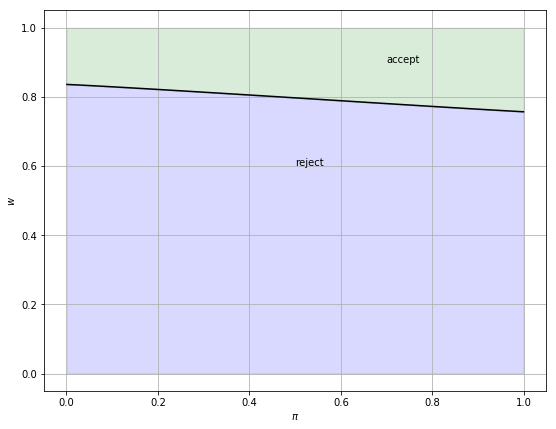

In [10]:
sp = SearchProblem()
w_bar = solve_wbar(sp)

fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(sp.π_grid, w_bar, color='k')
ax.fill_between(sp.π_grid, 0, w_bar, color='blue', alpha=0.15)
ax.fill_between(sp.π_grid, w_bar, sp.w_max, color='green', alpha=0.15)
ax.text(0.5, 0.6, 'reject')
ax.text(0.7, 0.9, 'accept')
ax.set(xlabel='$\pi$', ylabel='$w$')
ax.grid()
plt.show()

## Appendix

The next piece of code is just a fun simulation to see what the effect of a change in the
underlying distribution on the unemployment rate is

At a point in the simulation, the distribution becomes significantly worse

It takes a while for agents to learn this, and in the meantime they are too optimistic,
and turn down too many jobs

As a result, the unemployment rate spikes

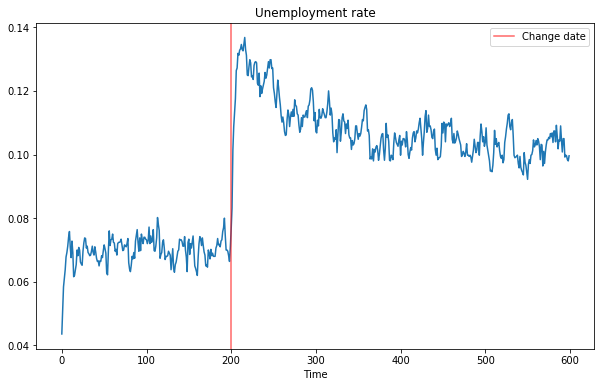

In [11]:
F_a, F_b, G_a, G_b = 1, 1, 3, 1.2

sp = SearchProblem(F_a=F_a, F_b=F_b, G_a=G_a, G_b=G_b)
f, g = sp.f, sp.g

# Solve for reservation wage
w_bar = solve_wbar(sp, verbose=False)

# Interpolate reservation wage function
π_grid = sp.π_grid
w_func = njit(lambda x: interp(π_grid, w_bar, x))

@njit
def update(a, b, e, π):
    "Update e and π by drawing wage offer from beta distribution with parameters a and b."

    if e == False:
        w = np.random.beta(a, b)       # Draw random wage
        if w >= w_func(π):
            e = True                   # Take new job
        else:
            π = 1 / (1 + ((1 - π) * g(w)) / (π * f(w)))

    return e, π

@njit
def simulate_path(F_a=F_a,
                  F_b=F_b,
                  G_a=G_a,
                  G_b=G_b,
                  N=5000,       # Number of agents
                  T=600,        # Simulation length
                  d=200,        # Change date
                  s=0.025):     # Separation rate

    """Simulates path of employment for N number of works over T periods."""

    e = np.ones((N, T+1))
    π = np.ones((N, T+1)) * 1e-3

    a, b = G_a, G_b   # Initial distribution parameters

    for t in range(T+1):

        if t == d:
            a, b = F_a, F_b  # Change distribution parameters

        # Update each agent
        for n in range(N):
            if e[n, t] == 1:                    # If agent is currently employment
                p = np.random.uniform(0, 1)
                if p <= s:                      # Randomly separate with probability s
                    e[n, t] = 0

            new_e, new_π = update(a, b, e[n, t], π[n, t])
            e[n, t+1] = new_e
            π[n, t+1] = new_π

    return e[:, 1:]

d = 200  # Change distribution at time d
unemployment_rate = 1 - simulate_path(d=d).mean(axis=0)

plt.figure(figsize=(10, 6))
plt.plot(unemployment_rate)
plt.axvline(d, color='r', alpha=0.6, label='Change date')
plt.xlabel('Time')
plt.title('Unemployment rate')
plt.legend()
plt.show()